In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import xgboost as xgb
from sklearn.metrics import log_loss

from scipy.stats import randint, uniform
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load data

In [14]:
train = pd.read_csv('train2.csv')
test = pd.read_csv('test2.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# New feature

In [15]:
win = []
loss = []

for i in range(train.shape[0]):

    if train.target[i] == True:
        win.append(train.team1[i])
        loss.append(train.team2[i])
        
    if train.target[i] == False:
        win.append(train.team2[i])
        loss.append(train.team1[i])    

In [16]:
DF = pd.DataFrame(columns=['team', 'wins', 'losses'])

unique_teams = list(set(list(train.team1) + list(train.team2)))

for team in unique_teams:
    wins = win.count(team)
    losses = loss.count(team)
    
    
    DF = DF.append(pd.DataFrame([[team, wins, losses]], 
                                columns=['team', 'wins', 'losses']), 
                   ignore_index=True)

In [17]:
DF['win_score'] = [DF['wins'][i] / (DF['wins'][i] + DF['losses'][i]) for i in range(DF.shape[0])]
DF[:4]

,team,wins,losses,win_score
0,2.0,225.0,355.0,0.387931
1,3.0,340.0,290.0,0.539683
2,4.0,412.0,257.0,0.615845
3,5.0,149.0,214.0,0.410468


In [18]:
def get_score_from_DF(team_number):
    for i in range(DF.shape[0]):
        if DF.team[i] == team_number:
            return DF.win_score[i] 

In [19]:
%%time

train['team1_win_score'] = 0.0
train['team2_win_score'] = 0.0

for i in range(train.shape[0]):
    
    train['team1_win_score'][i] = get_score_from_DF(train.team1[i])
    train['team2_win_score'][i] = get_score_from_DF(train.team2[i])

CPU times: user 8min 26s, sys: 843 ms, total: 8min 27s
Wall time: 8min 26s


In [43]:
train[:10]

,year,day,team1,team2,score1,score2,target,team1_win_score,team2_win_score
0,2998,19,317,131,336,278,True,0.696833,0.627803
1,2998,28,61,29,301,259,True,0.512945,0.553968
2,2998,28,110,141,359,267,True,0.535232,0.474732
3,2998,28,352,146,309,410,False,0.582946,0.787879
4,2998,28,229,91,332,220,True,0.672231,0.497653
5,2998,28,164,238,236,278,False,0.542768,0.650675
6,2998,28,184,243,181,224,False,0.462963,0.627586
7,2998,28,245,23,216,185,True,0.639761,0.531100
8,2998,28,300,349,402,321,True,0.681818,0.548287
9,2998,30,61,110,259,325,False,0.512945,0.535232


In [44]:
train.to_csv('train_winrate.csv')

# for test

In [24]:
test = test[['team1', 'team2']]

In [25]:
def get_score_from_DF(team_number):
    for i in range(DF.shape[0]):
        if DF.team[i] == team_number:
            return DF.win_score[i] 

In [26]:
%%time

test['team1_win_score'] = 0.0
test['team2_win_score'] = 0.0

for i in range(test.shape[0]):
    
    test['team1_win_score'][i] = get_score_from_DF(test.team1[i])
    test['team2_win_score'][i] = get_score_from_DF(test.team2[i])

CPU times: user 10min 30s, sys: 1.5 s, total: 10min 32s
Wall time: 10min 31s


In [32]:
test.to_csv('test_winrate.csv')

In [33]:
test[:2]

,team1,team2,team1_win_score,team2_win_score
0,363,161,0.429553,0.543511
1,286,2,0.579268,0.387931


# Get 2x train data due to symmetry

In [34]:
train_add = train.copy()
train_add['team1_win_score'] = train['team2_win_score']
train_add['team2_win_score'] = train['team1_win_score']
train_add['target'] = train_add['target'].astype(int).apply(lambda x: False if x == True else True)
train_add[:1]

,year,day,team1,team2,score1,score2,target,team1_win_score,team2_win_score
0,2998,19,317,131,336,278,False,0.627803,0.696833


In [35]:
train = pd.concat([train, train_add])
train.shape

(203218, 9)

#  Get features and target

In [36]:
features = ['team1_win_score', 'team2_win_score']
X = train[features]
y = train['target'].astype(int) 

In [37]:
X = X.values
y = y.values

In [38]:
X.shape

(203218, 2)

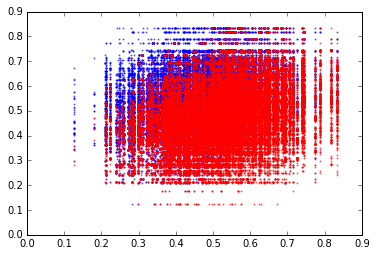

In [39]:
for i, color in enumerate(['blue', 'red']):
    plt.scatter(X[y==i][:, 0], X[y==i][:, 1], color=color, s=1., alpha=0.5)
plt.show()

In [40]:
train[:10]

,year,day,team1,team2,score1,score2,target,team1_win_score,team2_win_score
0,2998,19,317,131,336,278,True,0.696833,0.627803
1,2998,28,61,29,301,259,True,0.512945,0.553968
2,2998,28,110,141,359,267,True,0.535232,0.474732
3,2998,28,352,146,309,410,False,0.582946,0.787879
4,2998,28,229,91,332,220,True,0.672231,0.497653
5,2998,28,164,238,236,278,False,0.542768,0.650675
6,2998,28,184,243,181,224,False,0.462963,0.627586
7,2998,28,245,23,216,185,True,0.639761,0.531100
8,2998,28,300,349,402,321,True,0.681818,0.548287
9,2998,30,61,110,259,325,False,0.512945,0.535232


In [41]:
train.target[0]

0     True
0    False
Name: target, dtype: bool

# xgb cv

In [42]:
%%time

xgb_params = {
    'max_depth': 10, 
    'n_estimators': 1200,
    'learning_rate': 0.1,   
    'silent': 1,
    'nthread': 4,
    'subsample': 0.95, 
    'colsample_bytree': 0.95,
    'colsample_bylevel': 1.0,
    'min_child_weight': 2.0, 
    'scale_pos_weight': 1.0,
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metrics':'logloss', 
    'eta': 0.275,
    'alpha': 0.05,
    'gamma': 0.61,
    'seed':27
    }

skf = StratifiedKFold(n_splits=12, random_state=0, shuffle=True)

res = []
for train_idx, test_idx in skf.split(X, y):
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]  
        
    Xdatatrain = xgb.DMatrix(data=X_train, label=y_train)
    Xdatatest = xgb.DMatrix(data=X_test, label=y_test)
    
    # training
    model = xgb.train(xgb_params, Xdatatrain, num_boost_round=2000)
    pred = model.predict(Xdatatest, ntree_limit=model.best_ntree_limit)
    
    loss = log_loss(y_test, pred)
    res.append(loss)
    
    print(loss)
    
#     xgb.plot_importance(model)
    
print(np.mean(res))

0.600650698064


KeyboardInterrupt: 

In [384]:
ss = sample_submission.copy()

ss.target = model.predict(xgb.DMatrix(test[features].values))
ss.to_csv('xgb.csv', index=False)

In [388]:
ss[:10]

,Id,target
0,0,0.126993
1,1,0.770981
2,2,0.949958
3,3,0.391128
4,4,0.244140
5,5,0.542561
6,6,0.069344
7,7,0.420363
8,8,0.478433
9,9,0.151851


In [386]:
ss_best = pd.read_csv('xgb_best.csv')

In [389]:
ss_best[:10]

,Id,target
0,0,0.116560
1,1,0.763639
2,2,0.957009
3,3,0.410184
4,4,0.298425
5,5,0.469387
6,6,0.067073
7,7,0.404412
8,8,0.478507
9,9,0.511290


In [399]:
ss_mean =  sample_submission.copy()
ss_mean.target = 0.7*ss_best.target + 0.3*ss.target
ss_mean[:10]

,Id,target
0,0,0.119690
1,1,0.765841
2,2,0.954894
3,3,0.404467
4,4,0.282140
5,5,0.491339
6,6,0.067754
7,7,0.409197
8,8,0.478485
9,9,0.403459


In [400]:
ss_mean.to_csv('xgb_mean.csv', index=False)

# LR

In [40]:
from sklearn.cross_validation import ShuffleSplit

for itr, ite in ShuffleSplit(len(train), n_iter=1, train_size=0.4, test_size=0.1, random_state=0):
    pass

In [41]:
xtrain = train.loc[itr, features]    
ytrain = train.loc[itr, 'target']

xval = train.loc[ite, features]
yval = train.loc[ite, 'target']

In [42]:
test = test[features].fillna(0)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [44]:
from sklearn.cross_validation import ShuffleSplit

for itr, ite in ShuffleSplit(len(train), n_iter=1, train_size=0.4, test_size=0.1, random_state=0):
    pass

In [ ]:
clf_lr = LogisticRegression(random_state=0)

skf = StratifiedKFold(n_splits=12, shuffle=True, random_state=0)
grid_lr = {'C': np.logspace(-4, 2, 7)}

clf_lr_grid = GridSearchCV(clf_lr, grid_lr, cv=skf, scoring='neg_log_loss',  n_jobs=4)
clf_lr_grid.fit(xtrain, ytrain)

In [92]:
prediction = clf_lr_grid.predict_proba(xval)[:,1]

In [93]:
log_loss(yval, prediction)

0.62212539660151167

In [95]:
res_lr = clf_lr_grid.predict_proba(test[features])[:,1]
res_lr[:10]

array([ 0.33148282,  0.75990686,  0.87913103,  0.40849648,  0.21407348,
        0.39462817,  0.22753377,  0.71390518,  0.35023529,  0.67205266])

# LR : add 0.1 part?

In [97]:
ss_best = pd.read_csv('xgb_best.csv')
ss = pd.read_csv('xgb.csv')

In [98]:
ss_mean1 =  sample_submission.copy()
ss_mean1.target = 0.6*ss_best.target + 0.3*ss.target + 0.1*res_lr
ss_mean1[:10]

,Id,target
0,0,0.141182
1,1,0.765468
2,2,0.947106
3,3,0.404298
4,4,0.273704
5,5,0.483863
6,6,0.083801
7,7,0.440147
8,8,0.465657
9,9,0.419535
